In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths and parameters
base_path = "/home/madse/Downloads/Fluxnet_Data/Alps/"
site_info = pd.read_csv("/home/madse/Downloads/Fluxnet_Data/site_info_all_FLUXNET2015.csv")
plot_data = False  # Set this to False if you don't want to plot the data
save_data = True  # Set this to False if you don't want to save the data
plot_boxplot = True  # Set this to False if you don't want to plot the boxplot

# Initialize a dictionary to hold min values for each site and year
min_nee_temp_dict = {}

# Iterate over all folders in the base path that start with "FLX_"
for folder in os.listdir(base_path):
    if folder.startswith("FLX_"):
        file_base = "_".join(folder.split("_")[0:4])
        years = "_".join(folder.split("_")[4:6])
        file_path = os.path.join(base_path, folder, f"{file_base}_HH_{years}.csv")
        
        # Extract site name
        site_name = folder.split("_")[1]
        # get PFT of site
        i = 0
        for site_i in site_info["site"]:
            if site_name == site_i:
                target_pft = site_info["pft"][i]
                if target_pft == "EBF":
                    target_pft = "DBF"  # TODO check OSH
                if target_pft == "OSH":
                    target_pft = "SHB"
                if site_name == "AT-Mie":
                    target_pft = "ENF"
            i += 1
        site_name = target_pft+"_"+site_name

        # Columns to read and converters
        columns_to_copy = [
            "TIMESTAMP_START",
            "TA_F",
            "NEE_VUT_REF",
            "NIGHT",
        ]
        converters = {k: lambda x: float(x) for k in columns_to_copy}

        # Load the data
        df_site = pd.read_csv(file_path, usecols=columns_to_copy, converters=converters)
        df_site["TIMESTAMP_START"] = pd.to_datetime(df_site["TIMESTAMP_START"], format="%Y%m%d%H%M")
        df_site["PFT"] = target_pft
        # Clean the data
        df_site['TA_F'] = df_site['TA_F'].replace(-9999.0, np.nan)
        df_site = df_site.dropna(subset=['TA_F'])
        df_site['NEE_VUT_REF'] = df_site['NEE_VUT_REF'].replace(-9999.0, np.nan)
        df_site = df_site.dropna(subset=['NEE_VUT_REF'])

        # Set the values to np.nan during nighttime
        night_columns = ['NEE_VUT_REF']
        df_site.loc[df_site['NIGHT'] == 1, night_columns] = np.nan

        # Convert units from micromol per m² per second to grams of Carbon per day
        #conversion_factor = 12 * 1e-6 * 60 * 60 * 24  # 12 g C per mol, micromol to mol, per second to per day
        #df_site['NEE_VUT_REF'] *= conversion_factor

        # Resample to daily frequency
        df_site.set_index('TIMESTAMP_START', inplace=True)
        df_daily = df_site.resample('D').agg({
            'TA_F': 'mean',
            'NEE_VUT_REF': 'mean'
        }).dropna()

        # Extract the year from the timestamp
        df_daily['YEAR'] = df_daily.index.year

        # List of unique years
        years = df_daily['YEAR'].unique()

        # Initialize site entry in the dictionary
        if site_name not in min_nee_temp_dict:
            min_nee_temp_dict[site_name] = {}

        # Plot for each year and find min NEE temperature
        for year in years:
            # Filter data for the current year
            df_year = df_daily[df_daily['YEAR'] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning

            # Group by each degree of temperature and calculate the mean values
            df_year.loc[:, 'TA_F_rounded'] = df_year['TA_F'].round()  # Use .loc to avoid SettingWithCopyWarning
            mean_values = df_year.groupby('TA_F_rounded').mean()

            # Fit a quadratic polynomial to the mean values
            coeffs = np.polyfit(mean_values.index, mean_values['NEE_VUT_REF'], 2)
            poly_fit = np.polyval(coeffs, mean_values.index)

            # Find the temperature at the minimum of the quadratic fit
            min_index = mean_values.index[np.argmin(poly_fit)]
            if min_index < 0 :
                min_index = np.nan
            min_value = poly_fit[np.argmin(poly_fit)]

            # Store the minimum temperature in the dictionary
            min_nee_temp_dict[site_name][year] = min_index
            if min_index < df_year['TA_F_rounded'].max():
                print(f'Topt is real for {year} at Site {site_name}')
                real_Topt_col = "green"
            else:
                real_Topt_col = "red"           

            # Optionally plot the data
            if plot_data:
                plt.figure(figsize=(10, 6))
                plt.scatter(df_year['TA_F'], df_year['NEE_VUT_REF'], color='grey', alpha=0.5, label='Data Points')
                plt.plot(mean_values.index, mean_values['NEE_VUT_REF'], color='blue', label='Mean Values')
                plt.plot(mean_values.index, poly_fit, color='red', label='Quadratic Fit')
                plt.scatter(min_index, min_value, color=real_Topt_col, s=100, label='Minimum Point')
                plt.xlabel('Mean daily temperature (TA_F)')
                plt.ylabel('Mean NEE (mumol/m²/s)')
                plt.title(f'Daily means of temperature vs NEE for {year} at Site {site_name}')
                plt.legend()
                plt.savefig(
                    os.path.join(base_path, "optimum_temp_"+site_name+"_"+str(year)+".eps"),
                    dpi=300,
                    bbox_inches="tight",
                )

# Convert the dictionary to a DataFrame
min_nee_temp_df = pd.DataFrame(min_nee_temp_dict).T

# Sort the DataFrame by site and year
min_nee_temp_df = min_nee_temp_df.sort_index(axis=0, ascending=True)

# Optionally save the DataFrame to a CSV file
if save_data:
    min_nee_temp_df.to_csv(os.path.join(base_path, 'min_Topt_from_nee_values.csv'))

print(min_nee_temp_df)


# Plot a boxplot of the temperatures where the minimum NEE occurs for each site
if plot_boxplot:
    # Convert the DataFrame to a long-form format suitable for plotting
    min_nee_temp_df_long = min_nee_temp_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Temperature')
    min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)

    plt.figure(figsize=(12, 8))
    # Create the boxplot
    min_nee_temp_df_long.boxplot(column='Temperature', by='Site', showfliers=True, vert=False, patch_artist=True,
                                boxprops=dict(facecolor='lightblue', color='black'),
                                whiskerprops=dict(color='black'),
                                capprops=dict(color='black'),
                                medianprops=dict(color='green', linewidth=2))
    
    plt.xlabel('optimum temperature (or min. of T_opt)')
    plt.ylabel('Site')
    plt.title('optimum Temperatures from FLUXNET2015 NEE_VUT_REF (or min. of T_opt)')
    plt.suptitle('')  # Remove the default 'Boxplot grouped by Site' title
    plt.grid(True)

    # Save the plot to an EPS file
    plt.savefig(
        os.path.join(base_path, "boxplot_Topt_Alps.eps"),
        dpi=300,
        bbox_inches="tight",
    )
    #plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# # Define paths and parameters
# base_path = "/home/madse/Downloads/Fluxnet_Data/Alps/"
# site_info = pd.read_csv("/home/madse/Downloads/Fluxnet_Data/site_info_all_FLUXNET2015.csv")
# plot_data = False  # Set this to False if you don't want to plot the data
# save_data = True  # Set this to False if you don't want to save the data
# plot_boxplot = True  # Set this to False if you don't want to plot the boxplot

# # Initialize a dictionary to hold min values for each site and year
# min_nee_temp_dict = {}
# # Initialize a dictionary to hold real_Topt_col information
# real_Topt_col_dict = {}

# # Iterate over all folders in the base path that start with "FLX_"
# for folder in os.listdir(base_path):
#     if folder.startswith("FLX_"):
#         file_base = "_".join(folder.split("_")[0:4])
#         years = "_".join(folder.split("_")[4:6])
#         file_path = os.path.join(base_path, folder, f"{file_base}_HH_{years}.csv")
        
#         # Extract site name
#         site_name = folder.split("_")[1]
#         # Get PFT of site
#         i = 0
#         for site_i in site_info["site"]:
#             if site_name == site_i:
#                 target_pft = site_info["pft"][i]
#                 if target_pft == "EBF":
#                     target_pft = "DBF"  # TODO check OSH
#                 if target_pft == "OSH":
#                     target_pft = "SHB"
#                 if site_name == "AT-Mie":
#                     target_pft = "ENF"
#             i += 1
#         site_name = target_pft + "_" + site_name

#         # Columns to read and converters
#         columns_to_copy = [
#             "TIMESTAMP_START",
#             "TA_F",
#             "NEE_VUT_REF",
#             "NIGHT",
#         ]
#         converters = {k: lambda x: float(x) for k in columns_to_copy}

#         # Load the data
#         df_site = pd.read_csv(file_path, usecols=columns_to_copy, converters=converters)
#         df_site["TIMESTAMP_START"] = pd.to_datetime(df_site["TIMESTAMP_START"], format="%Y%m%d%H%M")
#         df_site["PFT"] = target_pft

#         # Clean the data
#         df_site['TA_F'] = df_site['TA_F'].replace(-9999.0, np.nan)
#         df_site = df_site.dropna(subset=['TA_F'])
#         df_site['NEE_VUT_REF'] = df_site['NEE_VUT_REF'].replace(-9999.0, np.nan)
#         df_site = df_site.dropna(subset=['NEE_VUT_REF'])

#         # Set the values to np.nan during nighttime
#         night_columns = ['NEE_VUT_REF']
#         df_site.loc[df_site['NIGHT'] == 1, night_columns] = np.nan

#         # Resample to daily frequency
#         df_site.set_index('TIMESTAMP_START', inplace=True)
#         df_daily = df_site.resample('D').agg({
#             'TA_F': 'mean',
#             'NEE_VUT_REF': 'mean'
#         }).dropna()

#         # Extract the year from the timestamp
#         df_daily['YEAR'] = df_daily.index.year

#         # List of unique years
#         years = df_daily['YEAR'].unique()

#         # Initialize site entry in the dictionary
#         if site_name not in min_nee_temp_dict:
#             min_nee_temp_dict[site_name] = {}
#             real_Topt_col_dict[site_name] = {}  # Initialize dictionary for real_Topt_col

#         # Plot for each year and find min NEE temperature
#         for year in years:
#             # Filter data for the current year
#             df_year = df_daily[df_daily['YEAR'] == year].copy()  # Use .copy() to avoid SettingWithCopyWarning

#             # Group by each degree of temperature and calculate the mean values
#             df_year['TA_F_rounded'] = df_year['TA_F'].round()  # Use .loc to avoid SettingWithCopyWarning
#             mean_values = df_year.groupby('TA_F_rounded').mean()

#             # Fit a quadratic polynomial to the mean values
#             coeffs = np.polyfit(mean_values.index, mean_values['NEE_VUT_REF'], 2)
#             poly_fit = np.polyval(coeffs, mean_values.index)

#             # Find the temperature at the minimum of the quadratic fit
#             min_index = mean_values.index[np.argmin(poly_fit)]
#             if min_index < 0:
#                 min_index = np.nan
#             min_value = poly_fit[np.argmin(poly_fit)]

#             # Store the minimum temperature in the dictionary
#             min_nee_temp_dict[site_name][year] = min_index
#             if min_index < df_year['TA_F_rounded'].max():
#                 print(f'Topt is real for {year} at Site {site_name}')
#                 real_Topt_col = "green"
#             else:
#                 real_Topt_col = "red"

#             # Store the real_Topt_col information
#             real_Topt_col_dict[site_name][year] = real_Topt_col

#             # Optionally plot the data
#             if plot_data:
#                 plt.figure(figsize=(10, 6))
#                 plt.scatter(df_year['TA_F'], df_year['NEE_VUT_REF'], color='grey', alpha=0.5, label='Data Points')
#                 plt.plot(mean_values.index, mean_values['NEE_VUT_REF'], color='blue', label='Mean Values')
#                 plt.plot(mean_values.index, poly_fit, color='red', label='Quadratic Fit')
#                 plt.scatter(min_index, min_value, color=real_Topt_col, s=100, label='Minimum Point')
#                 plt.xlabel('Mean daily temperature (TA_F)')
#                 plt.ylabel('Mean NEE (mumol/m²/s)')
#                 plt.title(f'Daily means of temperature vs NEE for {year} at Site {site_name}')
#                 plt.legend()
#                 plt.savefig(
#                     os.path.join(base_path, "optimum_temp_" + site_name + "_" + str(year) + ".eps"),
#                     dpi=300,
#                     bbox_inches="tight",
#                 )

# # Convert the dictionary to a DataFrame
# min_nee_temp_df = pd.DataFrame(min_nee_temp_dict).T


In [110]:

# Sort the DataFrame by site and year
min_nee_temp_df = min_nee_temp_df.sort_index(axis=0, ascending=True)

# Optionally save the DataFrame to a CSV file
if save_data:
    min_nee_temp_df.to_csv(os.path.join(base_path, 'min_Topt_from_nee_values.csv'))



# Convert the DataFrame to a long-form format suitable for plotting
min_nee_temp_df_long = min_nee_temp_df.reset_index().melt(id_vars='index', var_name='Year', value_name='Temperature')
min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)

# Create a DataFrame for the real_Topt_col information
real_Topt_col_df = pd.DataFrame([(site, year, col) for site, years in real_Topt_col_dict.items() for year, col in years.items()],
                                columns=['Site', 'Year', 'real_Topt_col'])

# Merge real_Topt_col information with the long-form DataFrame
min_nee_temp_df_long = min_nee_temp_df_long.merge(real_Topt_col_df, on=['Site', 'Year'])
min_nee_temp_df_long = min_nee_temp_df_long.sort_values("Site")
# Create a dictionary for site colors based on real_Topt
palette = min_nee_temp_df_long['real_Topt_col'].map({'green': 'green', 'red': 'red'})
print(min_nee_temp_df_long)

           Site  Year  Temperature real_Topt_col
83   CRO_CH-Oe2  2008         15.0         green
164  CRO_CH-Oe2  2013         26.0           red
27   CRO_CH-Oe2  2004         14.0         green
53   CRO_CH-Oe2  2006         27.0           red
99   CRO_CH-Oe2  2009         10.0         green
..          ...   ...          ...           ...
191  WET_CZ-wet  2014         23.0           red
162  WET_CZ-wet  2012         25.0           red
179  WET_DE-SfN  2013         22.0         green
163  WET_DE-SfN  2012          NaN           red
192  WET_DE-SfN  2014         18.0         green

[194 rows x 4 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


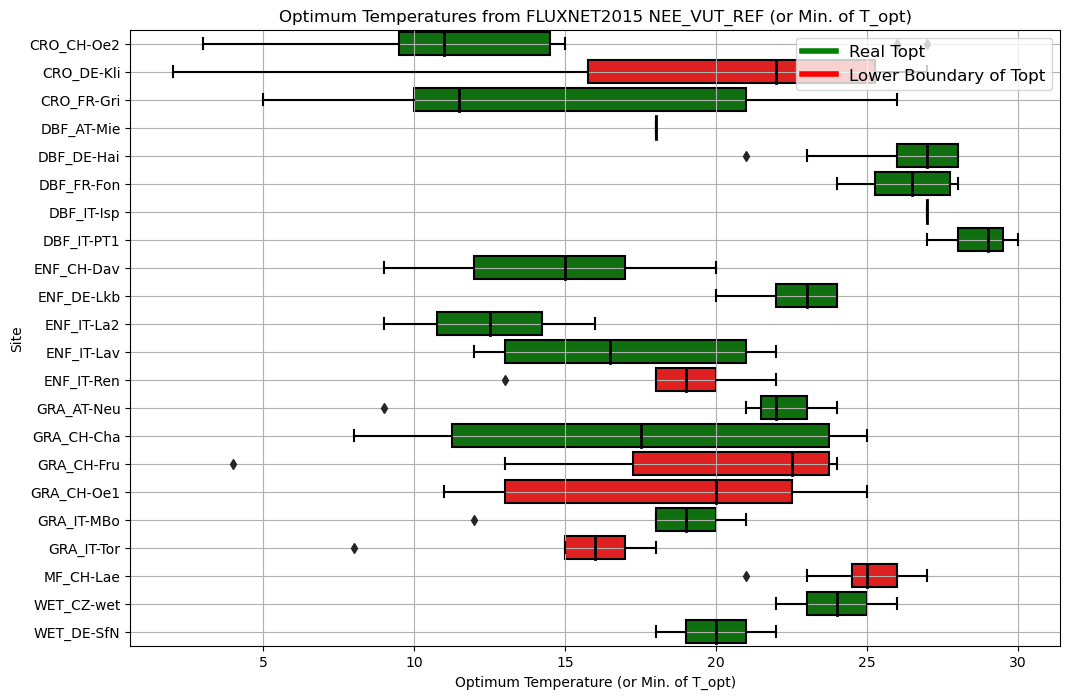

In [111]:

plt.figure(figsize=(12, 8))
# Create the boxplot
sns.boxplot(x='Temperature', y='Site', data=min_nee_temp_df_long, palette=palette, showfliers=True,
            boxprops=dict(edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black', linewidth=2))

plt.xlabel('Optimum Temperature (or Min. of T_opt)')
plt.ylabel('Site')
plt.title('Optimum Temperatures from FLUXNET2015 NEE_VUT_REF (or Min. of T_opt)')
plt.grid(True)
handles = [
    plt.Line2D([0], [0], color='green', lw=4, label='Real Topt'),
    plt.Line2D([0], [0], color='red', lw=4, label='Lower Boundary of Topt')
]
plt.legend(handles=handles, loc='upper right', fontsize=12)
# Save the plot to an EPS file
plt.savefig(
    os.path.join(base_path, "boxplot_optimum_temperatures.eps"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()
